<a href="https://colab.research.google.com/github/farenga/neuralODE/blob/main/2_Lotka_Volterra_Spiral_Ensemble_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral Lotka-Volterra Ensemble

Equations:

$$
\begin{cases}    
\dot{u_1}(t) = u_1(t)(\mu-0.1u_1(t)-0.5u_2(t)-0.5u_3(t))\\
\dot{u_2}(t) = u_2(t)(-\mu+0.5u_1(t)-0.3u_3(t))\\
\dot{u_3}(t) = u_3(t)(-\mu+0.2u_1(t)+0.5u_2(t))\\
u_i(0) = 0.5 \quad\end{cases} \qquad\mu = 1.95
$$

so since $\mathbf{f}(u(t),t,\theta)$

We tackle the problem by training 10 Neural ODEs models with different initializations, to build an ensamble model, allowing us to retrieve uncertainty-related infos.

In [24]:
!pip install torchdiffeq

In [25]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [26]:
method = 'dopr15'
data_size = 500
batch_time = 100            # number of data points per batch
n_batches = 32             # number of batches
epochs = 1500
test_freq = 50
gpu = 0
viz = False
adjoint = False
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [27]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [28]:
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t = torch.linspace(0., 12., data_size).to(device)

In [29]:
mu = 1.95

In [30]:
class Lambda(nn.Module):

    def forward(self, t, u):
      u1 = u[0][0]
      u2 = u[0][1]
      u3 = u[0][2]
      return torch.tensor([ 
                            [ u1*(mu - .1*u1 - .5*u2 - .5*u3) ],
                            [ u2*(-mu + .5*u1 - .3*u3) ],
                            [ u3*(-mu + .2*u1 + .5*u2) ]
                             
                             ]).reshape([1,3]).to(device)


In [31]:
with torch.no_grad():
    true_u = odeint(Lambda(), true_u0, t, method='dopri5') # [time,state] = [t,u(t)]

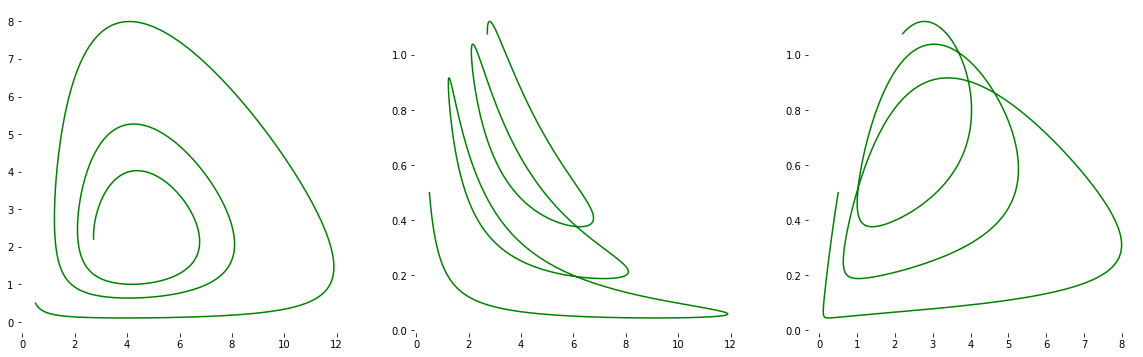

In [32]:
fig = plt.figure(figsize=(20, 6), facecolor='white')
ax_phase_1_true = fig.add_subplot(131, frameon=False)
ax_phase_1_true.plot(true_u[:, :, 0], true_u[:, :, 1], 'g-')
ax_phase_2_true = fig.add_subplot(132, frameon=False)
ax_phase_2_true.plot(true_u[:, :, 0], true_u[:, :, 2], 'g-')
ax_phase_3_true = fig.add_subplot(133, frameon=False)
ax_phase_3_true.plot(true_u[:, :, 1], true_u[:, :, 2], 'g-')

In [33]:
true_vector_field = torch.stack([Lambda.forward(0,t,u) for u in true_u])
true_vector_field

tensor([[[ 0.7000, -0.9250, -0.8000]],

        [[ 0.7337, -0.8781, -0.7733]],

        [[ 0.7688, -0.8336, -0.7470]],

        ...,

        [[-0.0547, -2.1209, -0.2771]],

        [[ 0.0233, -2.0702, -0.3027]],

        [[ 0.0999, -2.0185, -0.3268]]])

In [34]:
def get_batch():
    # randomly select initial time t0 for the batches
    # get randomly n_batches starting point by leaving the last 1 batch for testing
    s = torch.from_numpy(np.random.choice(np.arange(data_size - 2*batch_time, dtype=np.int64), n_batches, replace=False))
    # select the initial value for each batch
    batch_y0 = true_u[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_u[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    batch_y = batch_y + torch.randn_like(batch_y) *.1
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device), t[s]

In [35]:
batch_u0, batch_t, batch_u, ts = get_batch()
batch_u0.shape

torch.Size([32, 1, 3])

In [36]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [37]:
if viz:
    makedirs('png')
    fig = plt.figure(figsize=(20, 6), facecolor='white')
#   ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase_1 = fig.add_subplot(131, frameon=False)
    ax_phase_2 = fig.add_subplot(132, frameon=False)
    ax_phase_3 = fig.add_subplot(133, frameon=False)
#   ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [38]:
plot_x_lim = 3
plot_y_lim = 3

def visualize(true_u, pred_u, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_phase_1.cla()
        ax_phase_1.set_title('Phase Portrait, Species 1-2')
        ax_phase_1.set_xlabel('x1')
        ax_phase_1.set_ylabel('x2')
        ax_phase_1.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase_1.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase_1.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 1], 'r*')
        #ax_phase_1.set_xlim(0, plot_x_lim)
        #ax_phase_1.set_ylim(0, plot_y_lim)
        
        ax_phase_2.cla()
        ax_phase_2.set_title('Phase Portrait, Species 1-3')
        ax_phase_2.set_xlabel('x1')
        ax_phase_2.set_ylabel('x3')
        ax_phase_2.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_2.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_2.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_2.set_xlim(0, plot_x_lim)
        #ax_phase_2.set_ylim(0, plot_y_lim)

        ax_phase_3.cla()
        ax_phase_3.set_title('Phase Portrait, Species 2-3')
        ax_phase_3.set_xlabel('x2')
        ax_phase_3.set_ylabel('x3')
        ax_phase_3.plot(true_u.cpu().numpy()[:, 0, 1], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_3.plot(pred_u.cpu().numpy()[:, 0, 1], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_3.plot(batch_u0.cpu().numpy()[:, 0, 1], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_3.set_xlim(0, plot_x_lim)
        #ax_phase_3.set_ylim(0, plot_y_lim)

        
        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [39]:
class ODEFunc(nn.Module):
    def __init__(self,mu,sigma):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 100),
            nn.Tanh(),
            nn.Linear(100, 3)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=mu, std=sigma)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

# Extracted Data Visualization

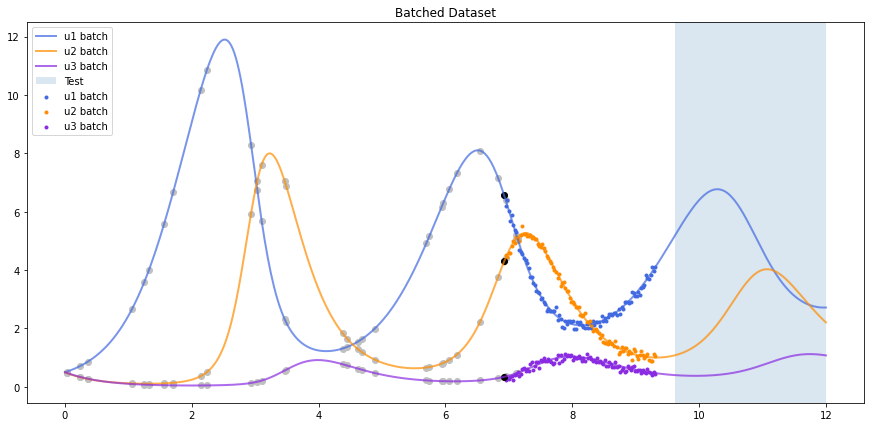

In [66]:
fig = plt.figure(figsize=(15, 7), facecolor='white',frameon=False)

batch_i=np.random.choice(range(32))
batched_time = batch_t + ts[batch_i]*torch.ones_like(batch_t)

colors = ['royalblue','darkorange','blueviolet']

for j in range(3):
  lab = 'u'+str(j+1)
  plt.scatter(ts,batch_u0[:,:,j],marker='o',color='silver')
  plt.plot(t,true_u[:, :, j],label=lab,color=colors[j],alpha=0.7,linewidth=2)
  plt.scatter(batched_time,batch_u[:,batch_i,:,j],label=lab+' batch',color=colors[j],marker='.')
  plt.scatter(batched_time[0],batch_u0[batch_i,:,j],color='black',marker='o')


#plt.plot(t,true_u[:, :, j],'--r',label='Ground truth')
plt.axvspan(t[data_size-batch_time], t[-1], facecolor='steelblue', alpha=0.2,label='Test')

plt.title('Batched Dataset')
plt.legend()

## Training

In [67]:
mu,sigma = 0,0.1
n_models = 10
ensemble = [ODEFunc(mu,sigma).to(device) for j in range(n_models)]

In [68]:
ensemble[0]

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [69]:
ii = 0

for i,func in enumerate(ensemble):

  print("Model #"+str(i))

  optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

  loss_array = []
  itr_time = []

  start = time.time()
  for itr in range(1, epochs + 1):
      
      start_itr = time.time()

      optimizer.zero_grad()
      
      batch_u0, batch_t, batch_u, ts = get_batch()
      pred_u = odeint(func, batch_u0, batch_t).to(device)
            
      loss = torch.mean(torch.pow(pred_u - batch_u,2))

      loss.backward()
      optimizer.step()
      
      itr_time.append(time.time()-start_itr)
      
      if itr % test_freq == 0:
        with torch.no_grad():
               loss_array.append(loss.item())
               print('Iter ' + str(itr)+'/'+str(epochs) + '  |  Loss: ' + str(round(loss.item(),6)) + '  |  lr: ' + str(optimizer.param_groups[0]['lr']) + ' |  itr time: ' +str(round(itr_time[-1],5))+' s')
       #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
       #       ii += 1

total_elapsed_time = time.time()-start

Model #0
Iter 50/1500  |  Loss: 4.302811  |  lr: 0.001 |  itr time: 0.08184 s
Iter 100/1500  |  Loss: 3.219688  |  lr: 0.001 |  itr time: 0.10589 s
Iter 150/1500  |  Loss: 2.094277  |  lr: 0.001 |  itr time: 0.10697 s
Iter 200/1500  |  Loss: 2.002762  |  lr: 0.001 |  itr time: 0.10964 s
Iter 250/1500  |  Loss: 1.589579  |  lr: 0.001 |  itr time: 0.12405 s
Iter 300/1500  |  Loss: 1.291905  |  lr: 0.001 |  itr time: 0.13523 s
Iter 350/1500  |  Loss: 1.662992  |  lr: 0.001 |  itr time: 0.13837 s
Iter 400/1500  |  Loss: 1.046044  |  lr: 0.001 |  itr time: 0.1602 s
Iter 450/1500  |  Loss: 1.466237  |  lr: 0.001 |  itr time: 0.1833 s
Iter 500/1500  |  Loss: 1.101442  |  lr: 0.001 |  itr time: 0.15846 s
Iter 550/1500  |  Loss: 0.642817  |  lr: 0.001 |  itr time: 0.16019 s
Iter 600/1500  |  Loss: 0.969176  |  lr: 0.001 |  itr time: 0.17459 s
Iter 650/1500  |  Loss: 0.715072  |  lr: 0.001 |  itr time: 0.17219 s
Iter 700/1500  |  Loss: 0.892897  |  lr: 0.001 |  itr time: 0.16917 s
Iter 750/1500 

In [73]:
print('Training time per model: {:f} min  |  avg time per epoch : {:f} s'.format(total_elapsed_time/60, np.mean(np.array(itr_time))))

Training time per model: 4.968586 min  |  avg time per epoch : 0.198730 s


## Test

In [74]:
def ensemble_pred(ensemble, u0, t):
  pred = torch.stack([odeint(func, true_u0, t).to(device) for func in ensemble])
  mean_pred = torch.mean(pred,0)
  std_pred = torch.std(pred,0)
  return pred,mean_pred,std_pred

In [75]:
pred,mean_pred,std_pred = ensemble_pred(ensemble, true_u0, t)

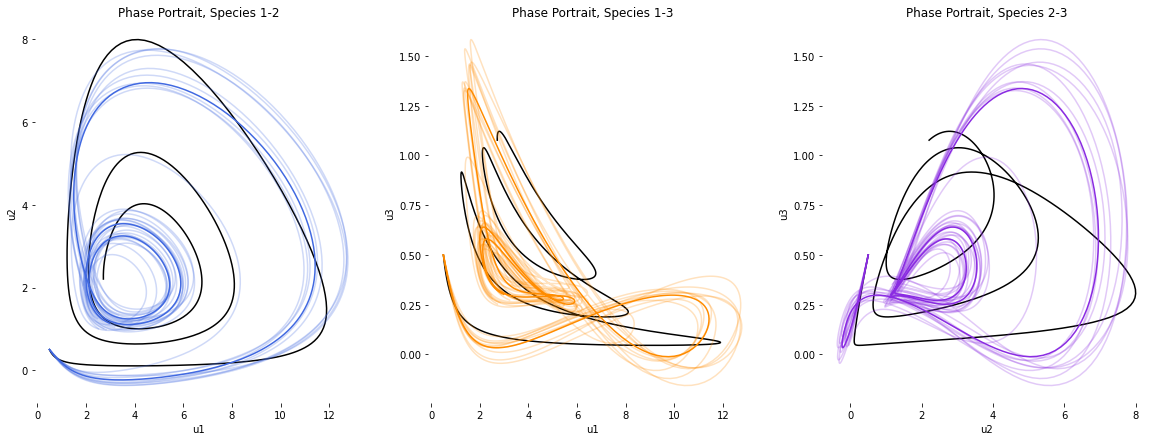

In [76]:
with torch.no_grad():

  fig = plt.figure(figsize=(20, 7), facecolor='white')

  gtc = '#000000'
  ax_phase_1_test = fig.add_subplot(131, frameon=False)
  ax_phase_1_test.set_title('Phase Portrait, Species 1-2')
  ax_phase_1_test.set_xlabel('u1')
  ax_phase_1_test.set_ylabel('u2')
  ax_phase_1_test.plot(true_u[:, :, 0], true_u[:, :, 1], '-', color=gtc)
  ax_phase_1_test.plot(mean_pred[:, :, 0], mean_pred[:, :, 1], '-', color=colors[0])


  ax_phase_2_test = fig.add_subplot(132, frameon=False)
  ax_phase_2_test.set_title('Phase Portrait, Species 1-3')
  ax_phase_2_test.set_xlabel('u1')
  ax_phase_2_test.set_ylabel('u3')
  ax_phase_2_test.plot(true_u[:, :, 0], true_u[:, :, 2], '-', color=gtc)
  ax_phase_2_test.plot(mean_pred[:, :, 0], mean_pred[:, :, 2], '-', color=colors[1])


  ax_phase_3_test = fig.add_subplot(133, frameon=False)
  ax_phase_3_test.set_title('Phase Portrait, Species 2-3')
  ax_phase_3_test.set_xlabel('u2')
  ax_phase_3_test.set_ylabel('u3')
  ax_phase_3_test.plot(true_u[:, :, 1], true_u[:, :, 2], '-', color=gtc)
  ax_phase_3_test.plot(mean_pred[:, :, 1], mean_pred[:, :, 2], '-', color=colors[2])

  a=.25
  for pred_u in pred:
    ax_phase_1_test.plot(pred_u[:, :, 0], pred_u[:, :, 1], '-', color=colors[0],alpha=a)
    ax_phase_2_test.plot(pred_u[:, :, 0], pred_u[:, :, 2], '-', color=colors[1],alpha=a)
    ax_phase_3_test.plot(pred_u[:, :, 1], pred_u[:, :, 2], '-',  color=colors[2],alpha=a)


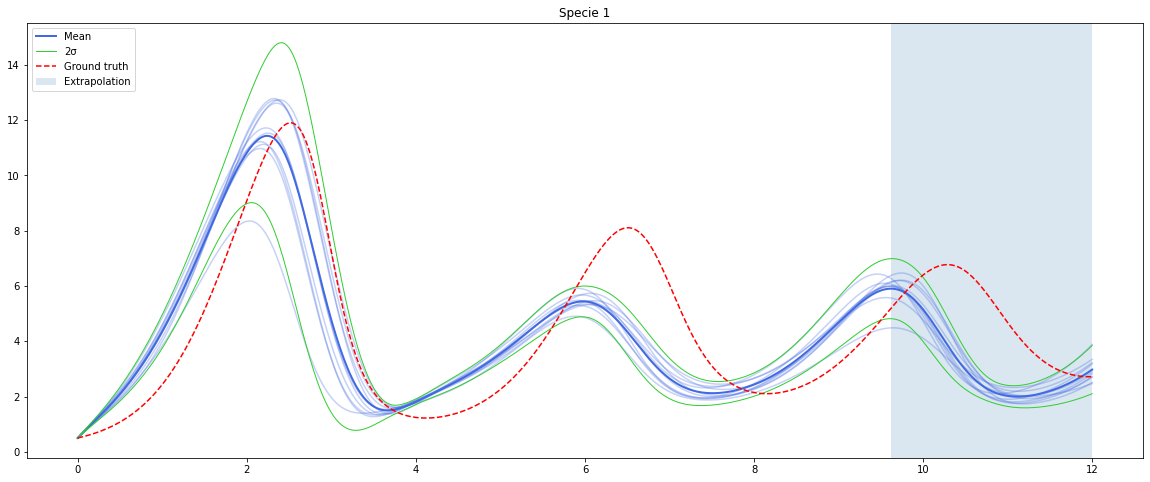

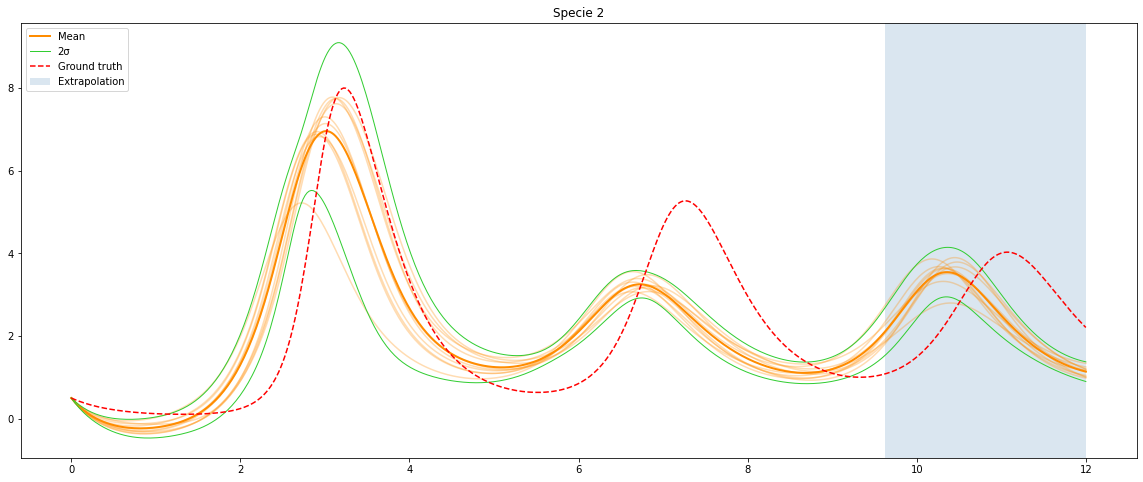

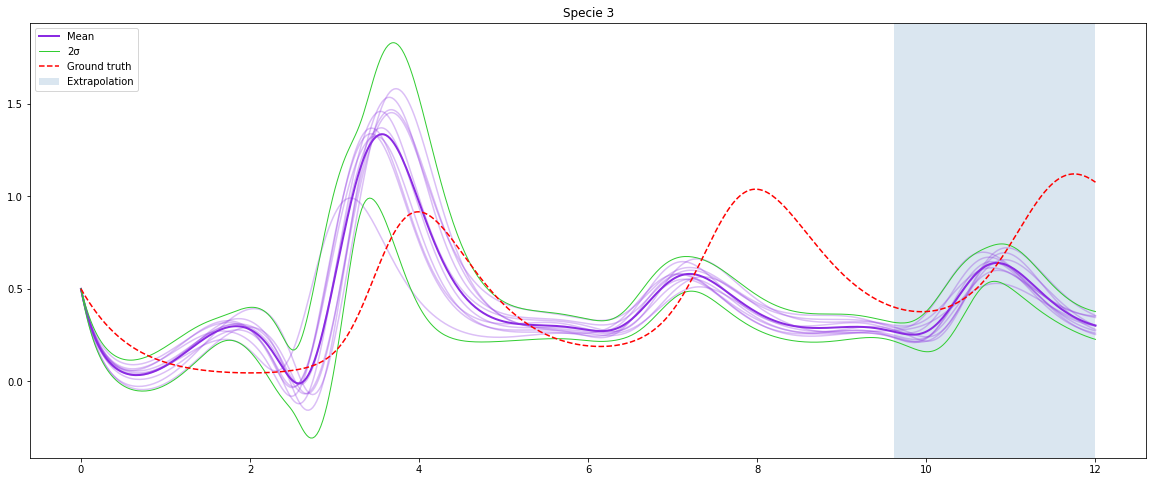

In [85]:
a = .3
for j in range(3):
  fig = plt.figure(figsize=(20, 8), facecolor='white',frameon=False)

  for pred_u in pred:
    plt.plot(t,pred_u[:, :, j].detach().numpy(),color=colors[j],alpha=a)

  plt.plot(t,mean_pred[:, :, j].detach().numpy(),color=colors[j],linewidth=2,label='Mean')
  plt.plot(t,mean_pred[:, :, j].detach().numpy()+2*std_pred[:, :, j].detach().numpy(),color='limegreen',label='2σ',linewidth=1)
  plt.plot(t,mean_pred[:, :, j].detach().numpy()-2*std_pred[:, :, j].detach().numpy(),color='limegreen',linewidth=1)
  #plt.scatter(batch_t,batch_u[:,0,:,j])
  plt.plot(t,true_u[:, :, j],'--r',label='Ground truth')
  plt.axvspan(t[data_size-batch_time], t[-1], facecolor='steelblue', alpha=0.2,label='Extrapolation')
  plt.title('Specie '+str(j+1))
  plt.legend()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


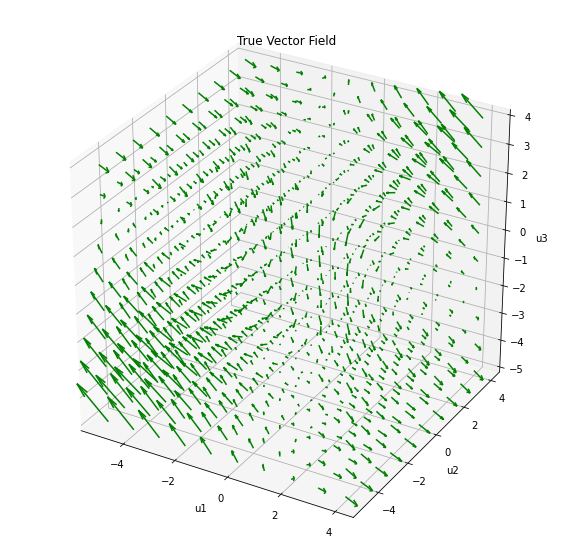

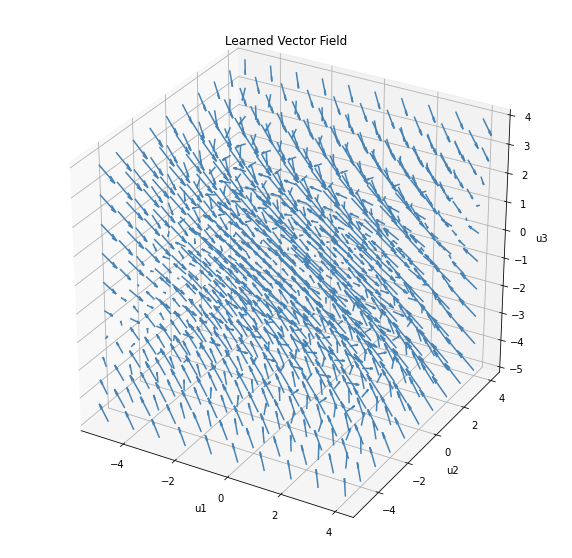

In [79]:
fig = plt.figure(figsize=(10,10))
ax_true_vf = fig.gca(projection='3d')

u1_lim,u2_lim,u3_lim = 5.,5.,5.
u1, u2, u3 = torch.meshgrid(torch.arange(-u1_lim,u1_lim,1.),torch.arange(-u2_lim,u2_lim,1.),torch.arange(-u3_lim,u3_lim,1.))

u = u1*(mu - .1*u1 - .5*u2 - .5*u3)
v = u2*(-mu + .5*u1 - .3*u3)
w = u3*(-mu + .2*u1 + .5*u2)

ax_true_vf.quiver(u1, u2, u3, u, v, w, length=0.05,color = 'green')
ax_true_vf.set_xlabel('u1')
ax_true_vf.set_ylabel('u2')
ax_true_vf.set_zlabel('u3')
ax_true_vf.set_title('True Vector Field')
#ax.view_init(20, 45)
plt.show()

func = ensemble[0]

fig = plt.figure(figsize=(10,10))
ax_learned_vf = fig.gca(projection='3d')

torch.stack([u1,u2,u3],-1)

mesh = torch.stack([u1,u2,u3],-1).reshape([len(u1)**3,1,3])
learned_vf = func(0,mesh)
learned_vf.shape
u = learned_vf[:,:,0].reshape(10,10,10).detach().numpy()
v = learned_vf[:,:,1].reshape(10,10,10).detach().numpy()
w = learned_vf[:,:,2].reshape(10,10,10).detach().numpy()

ax_learned_vf.quiver(u1,u2,u3,u,v,w,length=0.05,color='steelblue')

ax_learned_vf.set_xlabel('u1')
ax_learned_vf.set_ylabel('u2')
ax_learned_vf.set_zlabel('u3')
ax_learned_vf.set_title('Learned Vector Field')
#ax.view_init(20, 45)
plt.show()

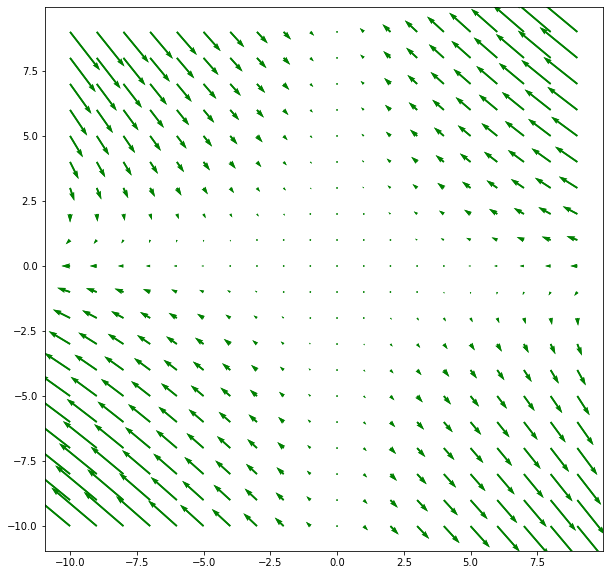

In [80]:
fig = plt.figure(figsize=(10,10))

u1_lim,u2_lim,u3_lim = 10.,10.,10.
u1, u2 = torch.meshgrid(torch.arange(-u1_lim,u1_lim,1.),torch.arange(-u2_lim,u2_lim,1.))
u3 = 0.
u1dot = u1*(mu - .1*u1 - .5*u2 - .5*u3)
u2dot = u2*(-mu + .5*u1 - .3*u3)

plt.quiver(u1, u2, u1dot, u2dot,color = 'green')


u = u1*(mu - .1*u1 - .5*u2 - .5*u3)
v = u2*(-mu + .5*u1 - .3*u3)

plt.quiver(u1, u2, u, v,color = 'green')


In [81]:
weights=[]
for w in ensemble[0].parameters():
  weights.append(w.detach().numpy())

Text(0.5, 1.0, 'Layer 2 Weights Distribution')

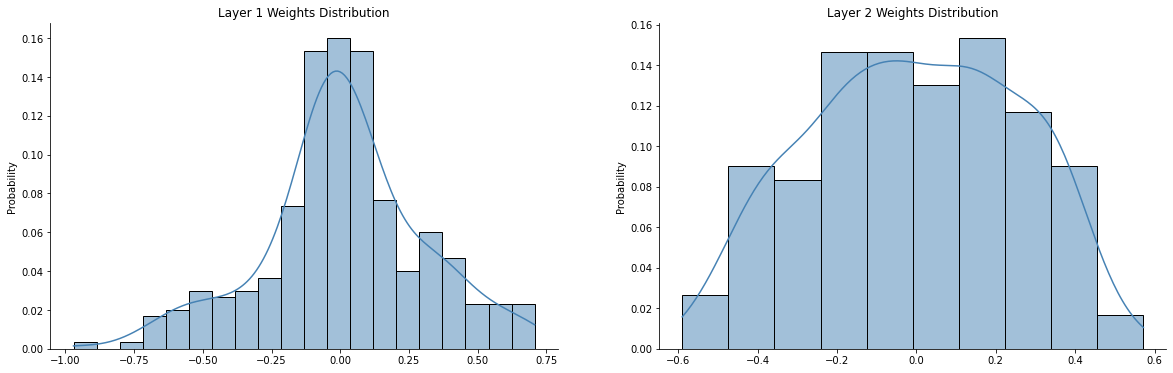

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.despine(fig)

sns.histplot(weights[0].reshape(300),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[0]).set_title('Layer 1 Weights Distribution')
sns.histplot(weights[2].reshape(300),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[1]).set_title('Layer 2 Weights Distribution')